In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

In [2]:
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold, preprocess_image, normalize
from src.utils import preprocess
from src.utils import plot
from src.utils.utils import split_custom_filename
from src.classifier.agent import Agent
from src.cam import CAM_TYPES, CAM
from src import segmentation
import nibabel as nib
import itertools

import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
from scipy import ndimage

***Defined dataloader:***
Data directory: data/SPM_categorised/Amira/
Dataset sizes - Training: 500 Validation: 56
Seed: 420
Augmentation: Enabled
KFold: Enabled - Fold: 1/10

Loading model from /var/metrics/codetests/logs/tb/resnet18_brew2/20210517212344/version_2/checkpoints/epoch=99-step=6299.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet18_brew2', 'args': {'num_channels': 1, 'num_classes': 3}}
"checkpoint_path":     None
"class_weights":       tensor([1.1905, 0.9259, 0.9259])
"hp_metrics":          ['loss/train', 'loss/val', 'Accuracy/val', 'AUROC/val', 'Precision/val', 'Recall/val', 'Specificity/val']
"loss":                {'type': 'CrossEntropyLoss', 'args': {'weight': True}}
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0001, 'weight_decay': 0, 'amsgrad': True}}
"roi_hparams":         {'enable': False, 'output_shape': [3, 3, 3], 'boundary_boxes': []}
"weight_distribution": normal


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


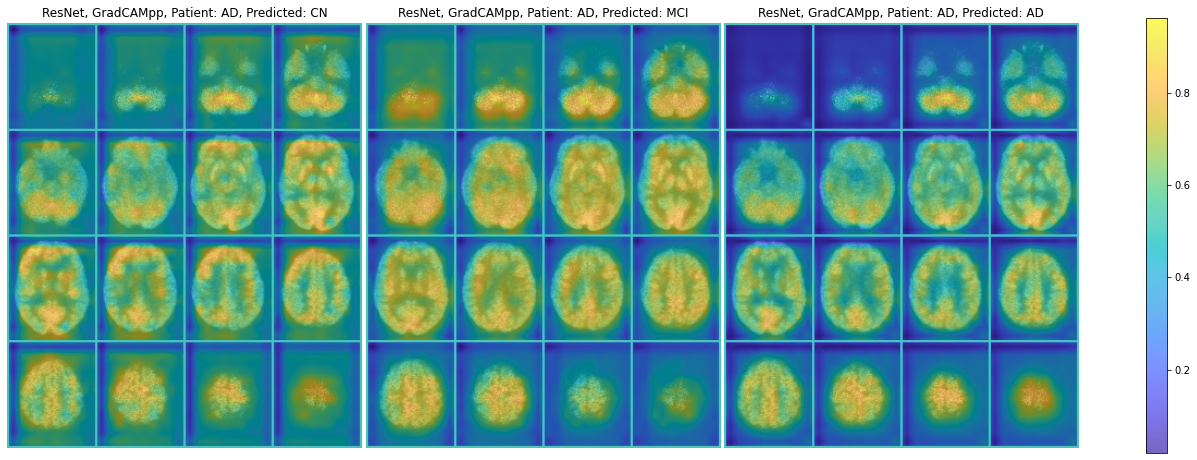

In [4]:
# Load models #resnet18_brew2/20210502200453/version_0/checkpoints/epoch=81-step=5083.ckpt
#resnet50/20210501144041/version_0/checkpoints/epoch=56-step=3533.ckpt"
trainer = Agent('resnet18_brew2', checkpoint_path="/var/metrics/codetests/logs/tb/resnet18_brew2/20210517212344/version_2/checkpoints/epoch=99-step=6299.ckpt")#"/var/metrics/codetests/logs/tb/resnet18_brew2/20210506180525/version_0/checkpoints/epoch=98-step=6236.ckpt")
trainer.load_model()
#trainer.run()
model = trainer.model
dataset = trainer.dataloader
#cam_extractor = CAM(CAM_TYPES.SmoothGradCAMpp.value, model, CAM_kwargs={"std":0.01})
cam_extractor = CAM(CAM_TYPES.GradCAMpp.value, model)
# Load example image
filename= '../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii'
#filename = '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii'
#filename = '../data/SPM_categorised/AIH/MCI/'
class_label = split_custom_filename(filename,'/')[4]
test_image = image2axial(nib.load(filename).get_fdata())
test_image[test_image <= 0]=0
test_image = preprocess_image(test_image)

class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], test_image,pad_value=0.5, max_num_slices=16, nrow=4)
masked_image = preprocess_image(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],test_image, max_num_slices=16, class_label=class_label,nrow=4);

***Defined dataloader:***
Data directory: data/SPM_categorised/Amira/
Dataset sizes - Training: 500 Validation: 56
Seed: 420
Augmentation: Enabled
KFold: Enabled - Fold: 1/10

Loading model from /var/metrics/codetests/logs/tb/resnet18_brew2/20210506180525/version_3/checkpoints/epoch=68-step=4346.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet18_brew2', 'args': {'num_channels': 1, 'num_classes': 3}}
"checkpoint_path":     None
"class_weights":       tensor([1.1905, 0.9259, 0.9259])
"hp_metrics":          ['loss/train', 'loss/val', 'Accuracy/val', 'AUROC/val', 'Precision/val', 'Recall/val', 'Specificity/val']
"loss":                {'type': 'CrossEntropyLoss', 'args': {'weight': True}}
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0001, 'weight_decay': 0, 'amsgrad': True}}
"roi_hparams":         {'enable': False, 'output_shape': [3, 3, 3], 'boundary_boxes': []}
"weight_distribution": normal


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


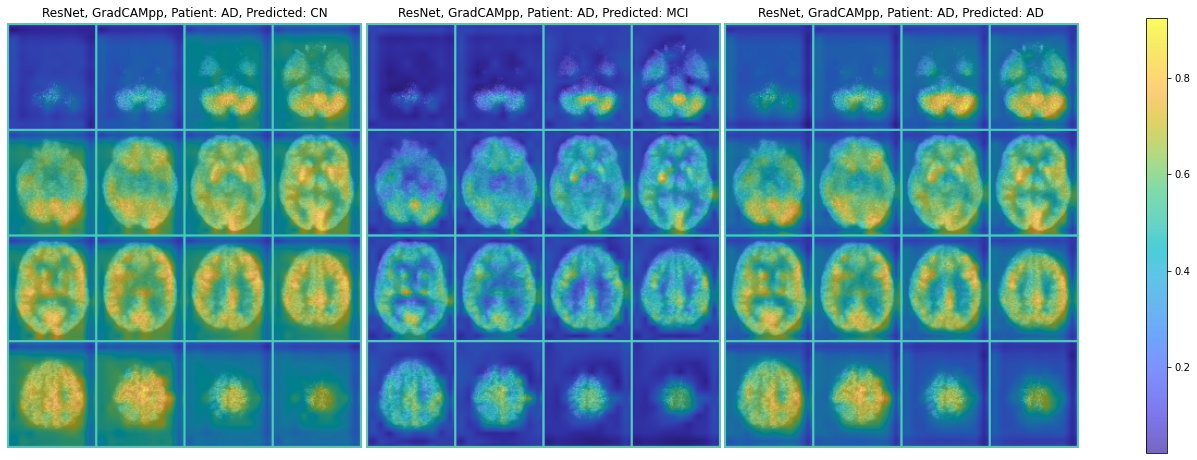

In [108]:
trainer = Agent('resnet18_brew2', checkpoint_path="/var/metrics/codetests/logs/tb/resnet18_brew2/20210506180525/version_3/checkpoints/epoch=68-step=4346.ckpt")
trainer.load_model()
model = trainer.model
#cam_extractor = CAM(CAM_TYPES.SmoothGradCAMpp.value, model, CAM_kwargs={"std":0.01})
cam_extractor = CAM(CAM_TYPES.GradCAMpp.value, model)
class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], test_image,pad_value=0.5, max_num_slices=16, nrow=4)
masked_image = preprocess_image(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],test_image, max_num_slices=16, class_label=class_label,nrow=4);

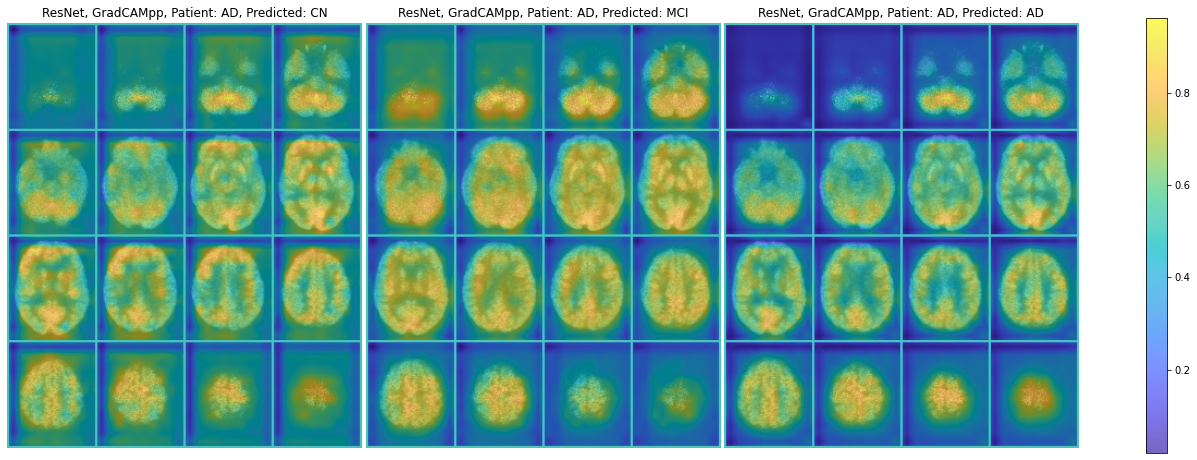

In [5]:
class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], test_image,pad_value=0.5, max_num_slices=16, nrow=4)
masked_image = preprocess_image(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],test_image, max_num_slices=16, class_label=class_label,nrow=4);

In [6]:
from src.classifier.dataloader import augmentation

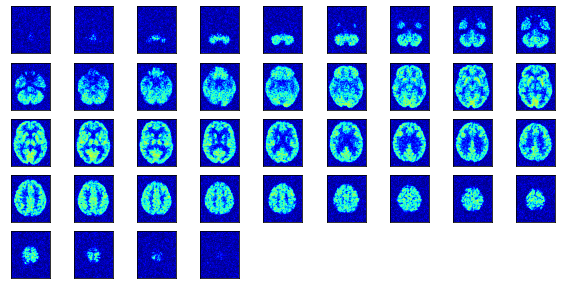

In [7]:
plot.display_3D(normalize(augmentation.augment(test_image)));

In [ ]:
from src.utils.plot import imshow
from src.utils.preprocess import to_grid
from src.utils.cmap import parula_map
import sys,os
import warnings
def calculate_average_cam(checkpoint_path, image, classes=[0,1,2],n=10):
    
    masks = []
   
    for i in range(n):
        
        trainer = Agent('resnet18_brew2', checkpoint_path=checkpoint_path)
        trainer.load_model()
        model = trainer.model
        cam_extractor = CAM(CAM_TYPES.GradCAMpp.value, model)
        class_scores, class_idx = cam_extractor.evaluate(image)
        grid_image, grid_mask = cam_extractor.grid_class(class_scores, classes, image,pad_value=0.5, max_num_slices=16, nrow=4)

        masks.append(grid_mask)
        del trainer,grid_mask, grid_image, model, cam_extractor, class_idx, class_scores

    return masks#preprocess_image(torch.mean(torch.stack(masks), axis=0))

# Load example image
#filename= '../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii'
#filename = '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii'
#filename = '../data/SPM_categorised/AIH/MCI/MCI_ADNI_1389.nii'
#sys.stdout = open(os.devnull, 'w')
for checkpoint in [
    "/var/metrics/codetests/logs/tb/resnet18_brew2/20210506180525/version_0/checkpoints/epoch=98-step=6236.ckpt", 
    "/var/metrics/codetests/logs/tb/resnet50/20210506203543/version_2/checkpoints/epoch=72-step=4598.ckpt",
    "/var/metrics/codetests/logs/tb/vgg16/20210506221224/version_0/checkpoints/epoch=46-step=2960.ckpt",
    "/var/metrics/codetests/logs/tb/vgg11_brew/20210507015717/version_3/checkpoints/epoch=112-step=7118.ckpt"
]:
    for filename in ['../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii', '../data/SPM_categorised/AIH/MCI/MCI_ADNI_1389.nii', '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii']:
        class_label = split_custom_filename(filename,'/')[4]
        test_image = image2axial(nib.load(filename).get_fdata())
        test_image[test_image <= 0]=0
        test_image = preprocess_image(test_image)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            maskes= calculate_average_cam(checkpoint, test_image)
        #/var/metrics/codetests/logs/tb/resnet50/20210506203543/version_4/checkpoints/epoch=58-step=3716.ckpt

        fig = plt.figure(figsize=(16,16))
        plt.imshow(normalize(np.hstack([to_grid(test_image, max_num_slices=16,nrow=4)]*3)),cmap='Greys_r')
        im = plt.imshow(normalize(torch.mean(torch.stack(maskes), axis=0)),cmap=parula_map, alpha=0.7) 
        plt.axis('off');
        plt.title(f"{class_label} - {checkpoint}")
        plt.show()
        del test_image, maskes
#sys.stdout = sys.__stdout__

In [50]:
sys.stdout = sys.__stdout__

In [83]:
print("hi")

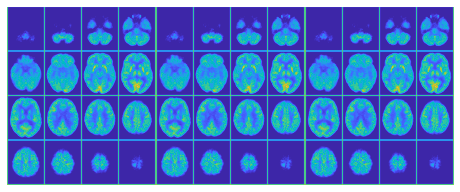

In [8]:
from src.utils.plot import imshow
imshow(grid_image)

In [9]:
from src.utils.plot import imshow
imshow(preprocess_image(grid_mask, input_shape=grid_image.shape), colormap=True,colormap_shrink=1, figsize=(18,6))

In [10]:

imshow(preprocess_image(grid_image, input_shape=grid_image.shape),cmap='gray', colormap=True,colormap_shrink=1, figsize=(18,6))

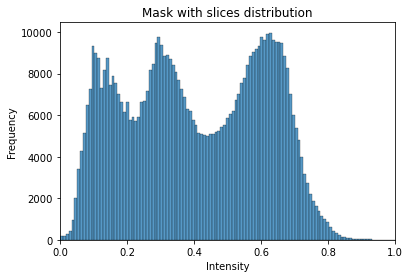

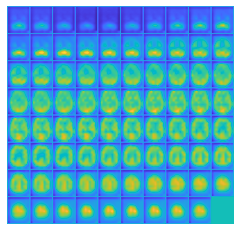

In [11]:
# Only check the distribution from each image! This looks a lot better!
sliced_masks = preprocess_image(cam_extractor.activation_map(2, class_scores))

# Remove background since this give faulty ideas otherwise
#sliced_masks[test_image == 0] = 0
#segmentation.intensity_distribution(sliced_masks[30].flatten(),title="Mask with slices distribution")
plot.intensity_distribution(sliced_masks.ravel(),title="Mask with slices distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

plot.imshow(preprocess.to_grid(sliced_masks))

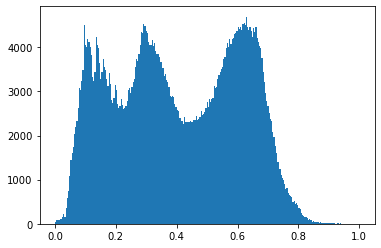

In [12]:
h, bins, patches = plt.hist(sliced_masks.ravel(), bins=255)

Tin = (h*sliced_masks.sum()).sum()/h.sum()

In [13]:
(h*sliced_masks.sum()).sum()/h.sum()

239626.0625

In [14]:
np.unique(sliced_masks.ravel())

array([0.0000000e+00, 4.8463822e-05, 1.1422634e-04, ..., 9.9050903e-01,
       9.9405009e-01, 1.0000000e+00], dtype=float32)

# Extract Segmentation and boundary boxes

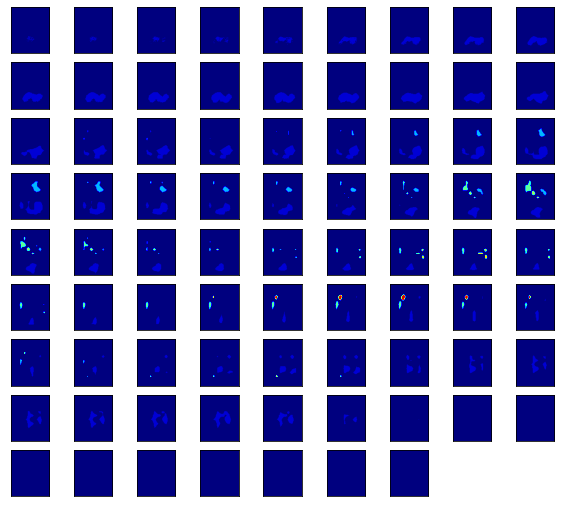

In [15]:
#features = segmentation.sequential_processing(test_image.copy(), sliced_masks.copy())
inner = segmentation.feature_extraction(cam_extractor, upper_bound=0.95,lower_bound=0.8,func='extract')
tmp_segmented = inner(torch.from_numpy(test_image),1)
plot.display_3D(tmp_segmented[0],step=1);
plot.display_3D(tmp_segmented[1],step=1);


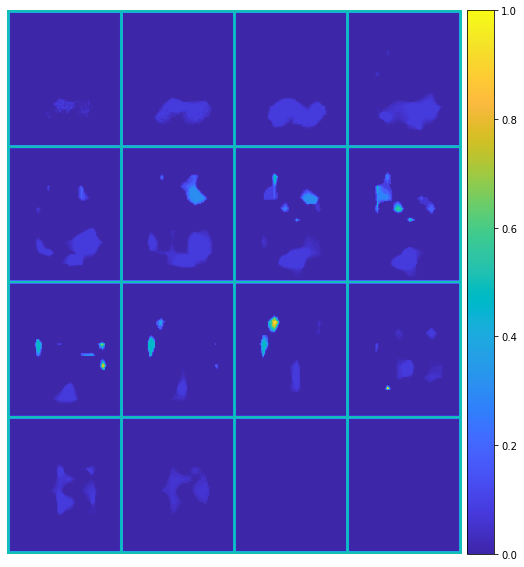

In [16]:
from src.utils.preprocess import to_grid
imshow(to_grid(tmp_segmented[0],max_num_slices=16, nrow=4), colormap=True, figsize=(10,10))

In [17]:
inner = segmentation.feature_extraction(cam_extractor, upper_bound=0.8,lower_bound=0.5,func='features')
features = inner((1,"Something", torch.from_numpy(test_image), 0,1))
features

{'image': 'Something',
 'patient_class': 0,
 'observe_class': 1,
 'probability_class': 1,
 'bbox_area': [369246, 1],
 'mean_intensity': [188.7409232106793, 178.0],
 'bbox': [(15, 11, 72, 93, 0, 79), (36, 56, 37, 57, 78, 79)],
 'upper_bound': 178.0,
 'lower_bound': 133.0,
 'use_quantile_bounds': True,
 'score': array([0.09614638, 0.7189295 ])}

# RoIAlign

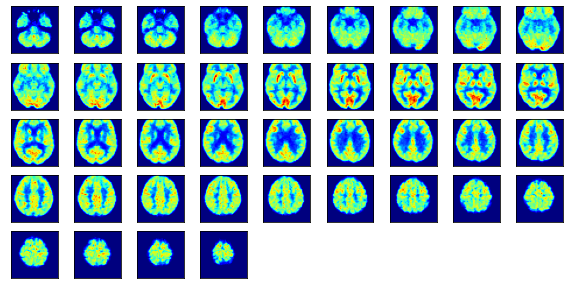

In [18]:
tmp_roialign = segmentation.roi_align(test_image, features['bbox'], displayed=True)
#imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=16, nrow=5), colormap=True)

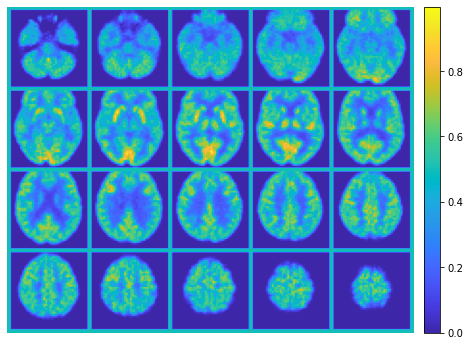

In [19]:
imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=25, nrow=5), colormap=True, figsize=(18,6))

../src/utils/preprocess.py:19: RuntimeWarning: invalid value encountered in true_divide
  return (x - x.min())/(x.max()-x.min())


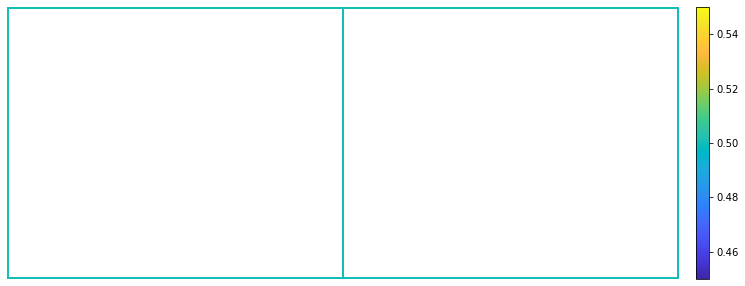

In [20]:
imshow(to_grid(np.stack([to_grid(tensor2numpy(x[0]),max_num_slices=25, nrow=5,pad_value=0.1) for x in tmp_roialign]), pad_value=0.5), colormap=True, figsize=(30,5))

In [21]:
#imshow(to_grid(test_image,max_num_slices=25, nrow=5),cmap='gray', colormap=True,colormap_shrink=1, figsize=(18,6))
#imshow(to_grid(sliced_masks,max_num_slices=25, nrow=5), colormap=True,colormap_shrink=1, figsize=(18,6))
#imshow(to_grid(tmp_segmented[0],max_num_slices=25, nrow=5), colormap=True, figsize=(18,6))
#[imshow(to_grid(np.stack([to_grid(tensor2numpy(x[0]),max_num_slices=25, nrow=5), colormap=True, figsize=(18,6)]))) for x in tmp_roialign]

## Extract all regions

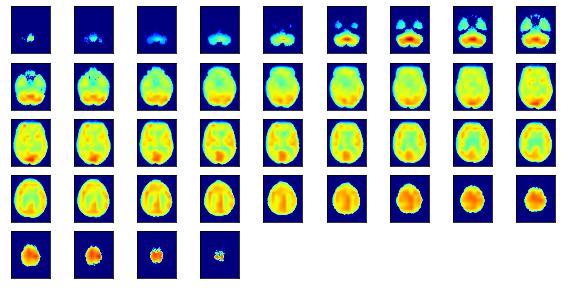

In [22]:
from src.utils.preprocess import to_grid
tmp_slices = sliced_masks.copy()
tmp_slices[test_image == 0] = 0
plot.display_3D(tmp_slices);

In [ ]:
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from src.utils.utils import create_directory
import os

CALCULATE_BBOX = True
BBOX_FILENAME = r'../logs/bbox/resnet50/bbox_2021-04-22 17:08:06.333885.csv'

if CALCULATE_BBOX:

    
    fileset = dataset.val_dataloader().dataset

    content = itertools.product(enumerate(fileset),[0,1,2])
    extraction_method = segmentation.feature_extraction(cam_extractor, upper_bound=0.95,lower_bound=0.5,)

    with ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(extraction_method,((i, fileset.data[i].rsplit("/",1)[1],image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in content))
    #derp = [extraction_method((i, fileset.data[i].rsplit("/",1)[1], image, patient_class, observe_class)) for (i, (image, patient_class)), observe_class in content]
    bboxes_dict = list(results)
    # Convert data to dataframe
    
    bboxes_df = pd.DataFrame(bboxes_dict)
    bboxes_df.rename(columns = {'index' : 'image', 'bbox':'bbox'}, inplace = True)
    bboxes_df['bbox_count'] = bboxes_df['bbox'].str.len()
    bboxes_df = bboxes_df[bboxes_df['bbox_count']>0]
    bboxes_df = bboxes_df.apply(pd.Series.explode)
    bboxes_df['bbox'] = bboxes_df['bbox'].apply(lambda row: list(row))
    
    bboxes_df.reset_index(inplace = True)
    bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
    bboxes_df.head(20)

    # Sort data
    bboxes_df.sort_values('score',ascending=False,inplace=True)
    
    # Save to logs
    
    now = datetime.now()
    name = f"../logs/bbox/{model._hparams['arch']['name']}/bbox_{now}.csv"
    os.makedirs(f"../logs/bbox/{model._hparams['arch']['name']}", exist_ok=True)
    bboxes_df.to_csv(name,index=False,header=True)

else:
    bboxes_df = pd.read_csv(BBOX_FILENAME, dtype={'patient_class':int, 'observe_class':int,'probability_class':int,'bbox_count':int})
    bboxes_df['bbox'] = segmentation.column_to_np(segmentation.column_to_tuple(bboxes_df['bbox']))

In [ ]:
bboxes_df.head(40)

# Check distributions for validating clusters

In [ ]:
bboxes_df.mean_intensity.hist() # x: snitt intensitet, y: Frekvens

In [ ]:
bboxes_df.bbox_area.hist() # x:storlek i pixlar, y: Frekvens

In [ ]:
def plot_bbox_category_scatter(bboxes_df, upper_limit=None, lower_limit=None):
    _bboxes_df = bboxes_df.copy()
    if upper_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']<=upper_limit]
    if lower_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']>=lower_limit]
    
    cn_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (_bboxes_df['patient_class'] == 0) ]
    mci_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (_bboxes_df['patient_class'] == 1)]
    ad_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (_bboxes_df['patient_class'] == 2)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    #plt.plot((100,240),(0,400000), color='red')
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [ ]:
bboxes_df.loc[(bboxes_df['bbox_area'] > 20000) & (bboxes_df['bbox_area'] < 170000)]

# Plot relation between area and intensity

In [ ]:
cn_bboxes, mci_bboxes, ad_bboxes = plot_bbox_category_scatter(bboxes_df, lower_limit=10000)

# Plot suggested bounding boxes for each class

In [ ]:
# show df for AD
ad_bboxes

In [ ]:
# show df for MCI
mci_bboxes

In [ ]:
# show df for CN
cn_bboxes

In [ ]:
# Plot bbox for AD
ad_interesting, fig = segmentation.interesting_bbox(ad_bboxes[ad_bboxes['score']>0.0],image_mask=test_image,th=0.1)
fig.suptitle("Non-maximum suppression on AD regions between area > 20000, Threshold: 0.5")

plt.show()

In [ ]:
ad_interesting

In [ ]:
# Plot bbox for MCI
mci_interesting, fig = segmentation.interesting_bbox(mci_bboxes[mci_bboxes['score']>0.0],image_mask=test_image, th=0.1)
fig.suptitle("Non-maximum suppression on MCI regions between area > 20000, Threshold: 0.8")
plt.show()

In [ ]:
# Plot bbox for CN
#cn_interesting,fig = segmentation.plot_interesting_bbox(cn_bboxes[(cn_bboxes['bbox_area'] <10000) & (cn_bboxes['bbox_area'] >1000)], th=0.1)
cn_interesting,fig = segmentation.interesting_bbox(cn_bboxes[cn_bboxes['score']>0], image_mask=test_image,th=0.1)

fig.suptitle("Non-maximum suppression on CN regions between 1000 < area < 10000, Threshold: 0.1")
plt.show()

In [ ]:
cn_interesting

In [ ]:
# Plot bbox for CN with another condition
cn_interesting2,fig = segmentation.interesting_bbox(cn_bboxes[cn_bboxes['score']>0.0], image_mask=test_image,th=0.1)
fig.suptitle("Non-maximum suppression on CN regions between area > 10000, Threshold: 0.1")
plt.show()

In [ ]:
def find_interesting_from_df(df_data, interesting_data):
    new_rows = df_data.apply(lambda row: row if list(row.bbox) in interesting_data.int().tolist() else 0, axis=1)
    return new_rows[new_rows['bbox'] != 0]

# Number of total boxes
print(ad_bboxes.shape[0])
print(mci_bboxes.shape[0])
print(cn_bboxes.shape[0])

In [ ]:
find_interesting_from_df(ad_bboxes, ad_interesting)

In [ ]:
find_interesting_from_df(mci_bboxes, mci_interesting)

In [ ]:
find_interesting_from_df(cn_bboxes, cn_interesting)

In [ ]:
print(f'AD: \n{ad_interesting.int()}\nMCI: \n{mci_interesting.int()}\nCN: \n{cn_interesting.int()}')

In [ ]:
# Create list of bbox that can be loaded.
merge_interesting_boxes = np.stack([*ad_interesting,*mci_interesting,*cn_interesting,*cn_interesting2])
merge_interesting_boxes

In [ ]:
# Roi extraction
segmentation.roi_align(test_image, merge_interesting_boxes, displayed=True);

In [48]:
""" https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
Step 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)
Step 2: Then, compare the overlap (intersection over union) of this box with other boxes 
Step 3: Remove the bounding boxes with overlap (intersection over union) >50%
Step 4: Then, move to the next highest objectiveness score
Step 5: Finally, repeat steps 2-4
"""

' https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/\nStep 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)\nStep 2: Then, compare the overlap (intersection over union) of this box with other boxes \nStep 3: Remove the bounding boxes with overlap (intersection over union) >50%\nStep 4: Then, move to the next highest objectiveness score\nStep 5: Finally, repeat steps 2-4\n'